In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [36]:
#!pip install numdifftools

In [37]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [38]:
#df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_2.csv")
#df = pd.read_csv("Bresnahan_data_full_inf.csv")
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/by%20markeder/Bresnahan_data_by.csv")


df = df.drop(['Unnamed: 0'], axis=1)

In [39]:
df['receptgrænse'] = 270000*1.02317**(df['År']-2011)

år = list(range(2008,2019))
# vi har indsat 0 i år efter 2015 for at sikre at disse markeder ikke er restrikteret
gnsrecept = [13.1, 13.12, 13.19, 13.13, 13.24, 13.26, 13.53, 13.13, 0 ,0 ,0]
gnsreceptdic = {}
for i in range(len(gnsrecept)):
    gnsreceptdic[år[i]] = gnsrecept[i]
    
restriction = []

for år in range(2008,2019):
    liste = list((df['Befolkning'][df['År']==år]*gnsreceptdic[år]-df['receptgrænse'][df['År']==år]*df['antal_apo'][df['År']==år])>=df['receptgrænse'][df['År']==år])
    for i in liste:
        restriction.append(i)
        
df['restriction'] = restriction

In [41]:
## FIX YDERKOMMUNER ##
df_komkode_yder = pd.read_excel('kommunerkoderyder.xlsx')
df = df.merge(df_komkode_yder, on = "Kommune")
df  = df.drop('yderkom', axis = 1)
df = df.rename(columns={'Yderkommuner':'yderkom'})

In [42]:
df['yder_mono'] = ((df['antal_apo']<=1)* (df['yderkom']==1))
df['yder_mono'] = df['yder_mono'].astype(int)

C:\Users\Camilla\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [43]:
# Fjerner København
#
#storbyer = [101, 147, 461, 751, 851] #
#storbyer = [101, 147, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 173, 175, 183, 185]

  
#for i in storbyer:
#    df = df[df['Kommune'] != i]
    
    
#df = df[df['Kommune'] != 101]
#df = df[df['Kommune'] != 147]
#df = df[df['Kommune']]

#år = [2008, 2009, 2010, 2011, 2012, 2013, 2014]
    

#df = df[(df['År'] == 2015) # & (df['År'] !=  2016) & (df['År'] !=  2017) & (df['År'] !=  2018)]

#df = df[(df['År'] != 2008) & (df['År'] !=  2009) & (df['År'] !=  2010) & (df['År'] !=  2011)& (df['År'] !=  2012)& (df['År'] !=  2013)& (df['År'] !=  2014)]
#df = df[(df['År'] == 2017)] & (df['År'] !=  2015)

df['logbefolkning'] = df['By_befolkning']/1000
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

# Unrestricted markets
df = df[df['restriction']==True]

In [45]:
def V(df, Ni, alpha=np.ones(5), beta=np.ones(6)):
    """Per-capita variable profit
    
    df: data
    Ni: number of incumbents in market i
    alpha: alpha parameters
    beta: beta parameter
    """
    n = np.min([5, Ni])
#     n = Ni
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    

    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK, df.yder_mono]# np.log()

    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
    
    
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(5)):
    n = np.min([5, Ni])
#     n = Ni
    g = 0
    # gamma 2 through gamma 5 (indices 1 through 4)
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[5]*df.logmarkedsvalue + g
    return fixed_cost

#def S_func(df, lam):
def S_func(df, lam): #, lam
    S =   lam * df.logbefolkning #np.log() #
    return S

#def neg_log_lik(theta=np.ones(19), market='TIRE', df=None):
def neg_log_lik(theta=np.ones(18), market='antal_apo', df=df):#, df=None):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 6
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[5] = np.log( Phi(Pi_bar(5)) )
    for i in range(1,5):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(6):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(5):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[5] * (df[market] >= 5))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:7]
    alpha = theta[7:12]
    gamma = theta[12:18]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta} 
    return d

In [46]:
theta0 = np.ones(18) * 0.1
neg_log_lik(df=df, theta=theta0)

C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


2311.017264840079

In [47]:
%%time
ba = [-np.inf] * 7
bb = [0] * 10
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 18
bounds = list(zip(lower_bounds, upper_bounds))


theta0 = np.ones(18) * 0.1
nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log


Wall time: 3min 32s


In [48]:
out

      fun: 886.3867567829931
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.03247213e-01,  5.78893378e-02, -1.44041223e-02, -2.08706297e-01,
       -8.15930434e-02, -1.88151716e-02, -3.06727088e-02,  1.75948571e+00,
        1.95973371e-01,  1.06717835e-01,  8.95302037e+00,  1.40445195e+01,
        3.97903932e-03,  2.43517206e-02,  1.80940560e+00, -8.52651283e-03,
        4.47016646e-01,  5.06497599e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14383
      nit: 681
   status: 0
  success: True
        x: array([ 0.17204015, -4.57234168, -2.48704706, -0.68600003,  0.50630523,
        4.00343246,  0.24761508,  0.        ,  0.36314199,  0.65001538,
        0.        ,  0.        ,  1.26279209,  3.49011547,  0.        ,
        3.73861237,  0.        ,  0.00723302])

In [49]:
Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))
results = pd.DataFrame({'parameters':out['x'],'std err':se})
results.index=['lambda - befolkning','beta_1 - d65','beta_2 - d17','beta_3 - indkomst','beta_4 - besk','beta_5 - Foreigner', 'beta_6 - yderkom','alpha_1','alpha_2','alpha_3','alpha_4','alpha_5','gamma_1','gamma_2','gamma_3','gamma_4','gamma_5', 'gamma_6 - Landvalue'] #,'gamma6'  


C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in log
C:\Users\Camilla\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
results

,parameters,std err
lambda - befolkning,0.17,nan
beta_1 - d65,-4.57,1.97
beta_2 - d17,-2.49,3.00
beta_3 - indkomst,-0.69,0.24
beta_4 - besk,0.51,2.92
beta_5 - Foreigner,4.00,1.70
beta_6 - yderkom,0.25,0.11
alpha_1,0.00,0.90
alpha_2,0.36,0.21
alpha_3,0.65,0.23


In [52]:
hat_theta = theta_to_param_dict(out.x)

In [53]:
hat_theta

{'lam': 0.17204015274660217,
 'beta': array([-4.57234168, -2.48704706, -0.68600003,  0.50630523,  4.00343246,
         0.24761508]),
 'alpha': array([0.        , 0.36314199, 0.65001538, 0.        , 0.        ]),
 'gamma': array([1.26279209, 3.49011547, 0.        , 3.73861237, 0.        ,
        0.00723302]),
 'theta': array([ 0.17204015, -4.57234168, -2.48704706, -0.68600003,  0.50630523,
         4.00343246,  0.24761508,  0.        ,  0.36314199,  0.65001538,
         0.        ,  0.        ,  1.26279209,  3.49011547,  0.        ,
         3.73861237,  0.        ,  0.00723302])}

In [54]:
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

1.3505922362302656
[1.54641622]
4.840707704757288
[1.18327423]
4.840707704757288
[0.53325885]
8.57932006986345
[0.53325885]
8.57932006986345
[0.53325885]


In [55]:
S_vals

array([ 0.87336916,  4.09094323,  9.07759471, 16.08847202, 16.08847202])

In [56]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,0.87,4.09,9.08,16.09,16.09


In [57]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']

In [58]:
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,2.34,1.48,1.33,0.80


In [59]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [60]:
SN_S5_ratio

array([3.68423177, 1.57308192, 1.06339658, 0.8       , 1.        ])

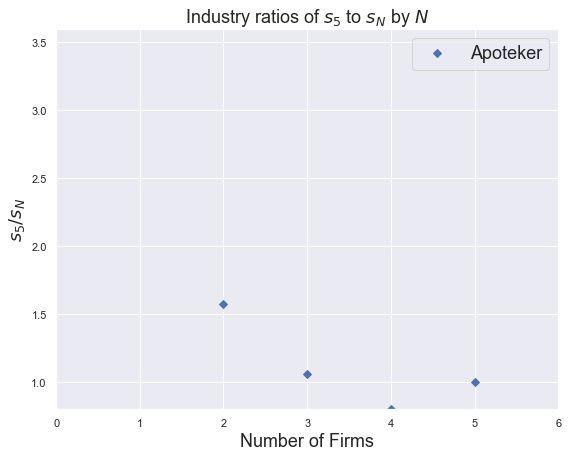

In [61]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.8, 3.6)
plt.title('Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)